In [10]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image

#Importing tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB5, EfficientNetB3,EfficientNetB1, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

For this I will be looking at the efficient Net models and comparing their performances

+ Let's start by creating important variables that we will use to create our train and validation generators

In [2]:
TRAIN_DATA_DIR="D:\Codes\Image-Classification\cardataset/train"
VALIDATION_DATA_DIR="D:\Codes\Image-Classification\cardataset/val"
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 17
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

+ Generators are great ways to augment data and make the process very easy without using any local storage space.


In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

+ Make the image fit the model input size so we don't have to do it one by one
+ Let's see the number of classes we have and the total number of images to get an idea of the dataset

In [4]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 22852 images belonging to 17 classes.
Found 5193 images belonging to 17 classes.


In [5]:
class_names=list((validation_generator.class_indices).keys())
class_names

['Ambulance',
 'Barge',
 'Bicycle',
 'Boat',
 'Bus',
 'Car',
 'Cart',
 'Caterpillar',
 'Helicopter',
 'Limousine',
 'Motorcycle',
 'Segway',
 'Snowmobile',
 'Tank',
 'Taxi',
 'Truck',
 'Van']

##### Create Model -> EfficientNet B5
+ In this we are using transfer learning techniques and so we first unfreeze the top layers and fine tune them according to our needs.
+ 

In [6]:
def model_maker(model=EfficientNetB5):
    base_model = model(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)
model_b5 = model_maker(model=EfficientNetB5)
model_b5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 17)                1105      
                                                             

In [9]:
model_b5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b5=model_b5.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 34s 2s/step - loss: 1.8369 - acc: 0.5425 - val_loss: 1.0493 - val_acc: 0.7773
Epoch 2/20
18/18 [==============================] - 27s 1s/step - loss: 0.8907 - acc: 0.7865 - val_loss: 0.9503 - val_acc: 0.7832
Epoch 3/20
18/18 [==============================] - 24s 1s/step - loss: 0.7853 - acc: 0.7986 - val_loss: 0.8911 - val_acc: 0.7832
Epoch 4/20
18/18 [==============================] - 24s 1s/step - loss: 0.7280 - acc: 0.8229 - val_loss: 0.8325 - val_acc: 0.7832
Epoch 5/20
18/18 [==============================] - 26s 1s/step - loss: 0.6152 - acc: 0.8333 - val_loss: 0.8086 - val_acc: 0.7891
Epoch 6/20
18/18 [==============================] - 24s 1s/step - loss: 0.5937 - acc: 0.8481 - val_loss: 0.7960 - val_acc: 0.7910
Epoch 7/20
18/18 [==============================] - 29s 2s/step - loss: 0.5892 - acc: 0.8490 - val_loss: 0.7240 - val_acc: 0.7988
Epoch 8/20
18/18 [==============================] - 27s 2s/step - loss: 0.6456 - acc: 0.83

In [11]:
hist_df_B5 = pd.DataFrame(hist_b5.history)
model_b5.save('model_EfficientNetB5.h5')

C:\Users\shzso\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### Creating Model Efficientnet B3

In [14]:
model_b3 = model_maker(model=EfficientNetB3)
model_b3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                98368     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 17)                1105      
                                                           

In [15]:

model_b3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b3=model_b3.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 31s 1s/step - loss: 1.8752 - acc: 0.4939 - val_loss: 1.2756 - val_acc: 0.7324
Epoch 2/20
18/18 [==============================] - 24s 1s/step - loss: 1.0599 - acc: 0.7405 - val_loss: 1.1131 - val_acc: 0.7539
Epoch 3/20
18/18 [==============================] - 32s 2s/step - loss: 0.8609 - acc: 0.7778 - val_loss: 1.0464 - val_acc: 0.7598
Epoch 4/20
18/18 [==============================] - 32s 2s/step - loss: 0.7634 - acc: 0.7995 - val_loss: 0.9127 - val_acc: 0.7734
Epoch 5/20
18/18 [==============================] - 32s 2s/step - loss: 0.7377 - acc: 0.8047 - val_loss: 0.8690 - val_acc: 0.7617
Epoch 6/20
18/18 [==============================] - 34s 2s/step - loss: 0.6500 - acc: 0.8168 - val_loss: 0.8702 - val_acc: 0.7656
Epoch 7/20
18/18 [==============================] - 26s 1s/step - loss: 0.6890 - acc: 0.8038 - val_loss: 0.8910 - val_acc: 0.7676
Epoch 8/20
18/18 [==============================] - 27s 1s/step - loss: 0.5613 - acc: 0.84

In [16]:
hist_df_B3 = pd.DataFrame(hist_b3.history) 
model_b3.save('model_EfficientNetB3.h5')

### Efficient net B0

In [7]:
model_b0 = model_maker(model=EfficientNetB0)
model_b0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 17)                1105      
                                                           

In [8]:

model_b0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b0=model_b0.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 37s 1s/step - loss: 2.0290 - acc: 0.4496 - val_loss: 1.5134 - val_acc: 0.7148
Epoch 2/20
18/18 [==============================] - 22s 1s/step - loss: 1.2388 - acc: 0.6960 - val_loss: 1.2590 - val_acc: 0.7559
Epoch 3/20
18/18 [==============================] - 23s 1s/step - loss: 1.0195 - acc: 0.7292 - val_loss: 1.1925 - val_acc: 0.7422
Epoch 4/20
18/18 [==============================] - 22s 1s/step - loss: 0.9389 - acc: 0.7344 - val_loss: 1.1433 - val_acc: 0.7402
Epoch 5/20
18/18 [==============================] - 22s 1s/step - loss: 0.8619 - acc: 0.7448 - val_loss: 1.1024 - val_acc: 0.7305
Epoch 6/20
18/18 [==============================] - 22s 1s/step - loss: 0.7974 - acc: 0.7847 - val_loss: 1.0865 - val_acc: 0.7480
Epoch 7/20
18/18 [==============================] - 22s 1s/step - loss: 0.6908 - acc: 0.7986 - val_loss: 1.0569 - val_acc: 0.7617
Epoch 8/20
18/18 [==============================] - 22s 1s/step - loss: 0.7617 - acc: 0.77

In [9]:
hist_df_B0 = pd.DataFrame(hist_b0.history) 
model_b0.save('model_EfficientNetB0.h5')

C:\Users\shzso\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


##### Model Efficient Net B1

In [11]:
model_b1 = model_maker(model=EfficientNetB1)
model_b1.summary()

27033600/27018416 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                81984     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 17)                1105 

In [12]:

model_b1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])
hist_b1=model_b1.fit(
    train_generator,
    steps_per_epoch=math.ceil(18),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/20
18/18 [==============================] - 25s 1s/step - loss: 1.9134 - acc: 0.4809 - val_loss: 1.4792 - val_acc: 0.6719
Epoch 2/20
18/18 [==============================] - 19s 1s/step - loss: 1.1787 - acc: 0.7143 - val_loss: 1.2146 - val_acc: 0.7246
Epoch 3/20
18/18 [==============================] - 20s 1s/step - loss: 0.8855 - acc: 0.7682 - val_loss: 1.1362 - val_acc: 0.7363
Epoch 4/20
18/18 [==============================] - 20s 1s/step - loss: 0.8289 - acc: 0.7760 - val_loss: 1.0978 - val_acc: 0.7266
Epoch 5/20
18/18 [==============================] - 20s 1s/step - loss: 0.7732 - acc: 0.7795 - val_loss: 1.0506 - val_acc: 0.7305
Epoch 6/20
18/18 [==============================] - 22s 1s/step - loss: 0.6662 - acc: 0.8116 - val_loss: 0.9744 - val_acc: 0.7363
Epoch 7/20
18/18 [==============================] - 26s 1s/step - loss: 0.6778 - acc: 0.8073 - val_loss: 0.9240 - val_acc: 0.7480
Epoch 8/20
18/18 [==============================] - 25s 1s/step - loss: 0.6851 - acc: 0.80

In [13]:
hist_df_B1 = pd.DataFrame(hist_b1.history) 
model_b1.save('model_EfficientNetB1.h5')

C:\Users\shzso\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [17]:

model_b5= tf.keras.models.load_model("model_EfficientNetB5.h5")
model_b3 = tf.keras.models.load_model("model_EfficientNetB3.h5")

In [18]:
def predict_image(img_path, model):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224,224])
    img=preprocess_input(img)
    img= tf.cast(tf.expand_dims(img, axis=0), tf.int16)
    #  


    prediction=model.predict(img)



    pred_class=class_names[tf.argmax(prediction[0])]
    pred_prob=(tf.reduce_max(prediction)*100).numpy()
    return pred_class,pred_prob

In [19]:
img_path = "D:\Downloads\photo-1558981403-c5f9899a28bc.jpg" #bike
img_path = "D:\Downloads/60825.jpg" #helicopter

predict_image(img_path=img_path,model=model_b3)

('Helicopter', 99.954865)

In [20]:
predict_image(img_path=img_path,model=model_b5)

('Helicopter', 99.25512)

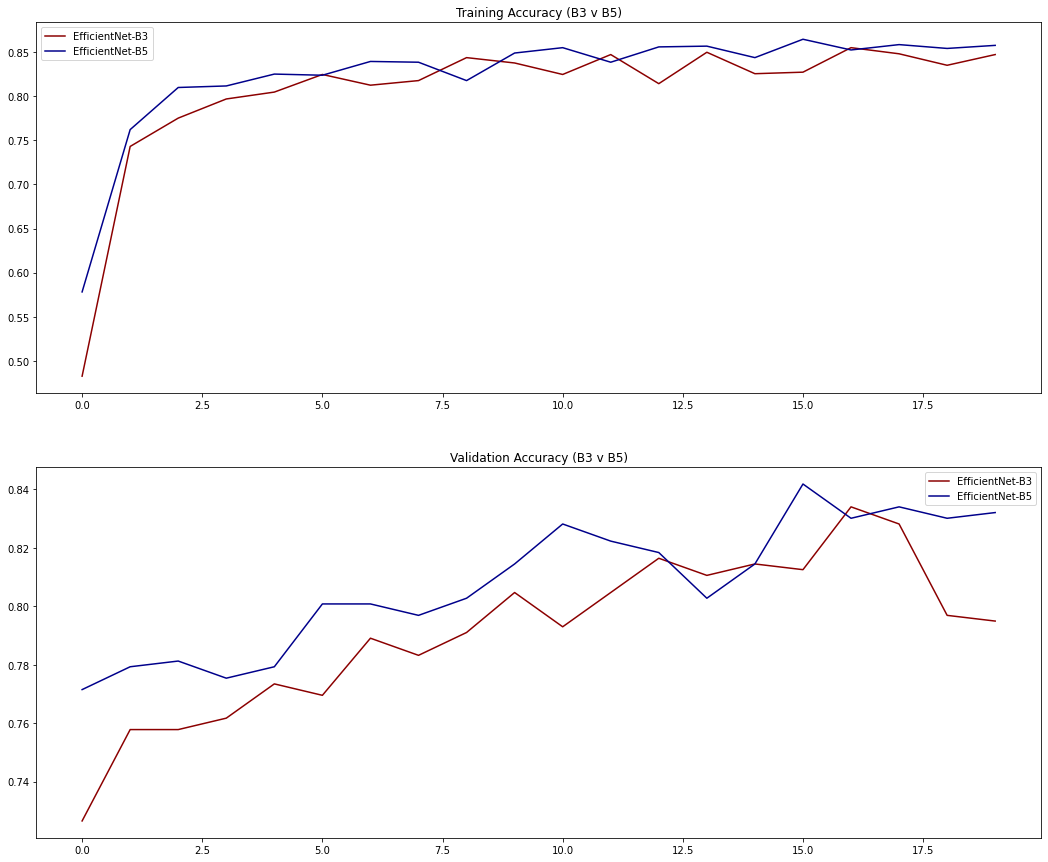

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(18,15))

ax1.plot(hist_df_B3.index,hist_df_B3['acc'],label='EfficientNet-B3',color='darkred')
ax1.plot(hist_df_B3.index,hist_df_B5['acc'],label='EfficientNet-B5',color='darkblue')
ax1.plot(hist_df_B3.index,hist_df_B1['acc'],label='EfficientNet-B1',color='darkgreen')
ax1.plot(hist_df_B3.index,hist_df_B0['acc'],label='EfficientNet-B0',color='darkorange')
ax1.legend()
ax1.title.set_text('Training Accuracy (B3 v B5)')

ax2.plot(hist_df_B3.index,hist_df_B3['val_acc'],label='EfficientNet-B3',color='darkred')
ax2.plot(hist_df_B3.index,hist_df_B5['val_acc'],label='EfficientNet-B5',color='darkblue')
ax2.plot(hist_df_B3.index,hist_df_B1['val_acc'],label='EfficientNet-B1',color='darkgreen')
ax2.plot(hist_df_B3.index,hist_df_B0['val_acc'],label='EfficientNet-B0',color='darkorange')
ax2.legend()
ax2.title.set_text('Validation Accuracy (B3 v B5)')

In [ ]:
### Best classified images v Worst classified images
